<a href="https://colab.research.google.com/github/Lelan30/Open-Projects/blob/main/Building_ETL_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Coding an ETL Pipeline**

The goal of the notebook is to combine these data sets together so that you can run a machine learning model predicting World Bank Project total costs.

# **Installs**

In [1]:
!pip install bs4 pycountry

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 60.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=c4c11140db0f8f7e9430ea83f9cf1154b4d068bf9448653684f6aec31f4827b2
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681833 sha256=7c68f2ebc110202652380ef91caaabadad657d98572a7999028581b20e8a78e9
  Stored in directory: /root/.cache/pip/wheels/03/57/cc/290c5252ec97a6d78d36479a3c5e5ecc76318afcb241ad9dbe
Successfully built bs4 pycountry


# **Imports**

In [2]:
# Imports
import requests
import numpy as np # Linear Algebra
import pandas as pd # Data processing
import json # read in json file
import sqlite3
import chardet

import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from bs4 import BeautifulSoup
from pycountry import countries
from collections import defaultdict
from encodings.aliases import aliases
from sklearn.linear_model import LinearRegression

# **Mount GDrive:**

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# **Configure Enviroment:**


# **Download Dataset:**


In [4]:
!kaggle datasets download -d nilaychauhan/world-bank-datasets

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


# **Extract**
Extract data from csv file:

In [5]:
import os
for dirname, _, filename in os.walk('/kaggle/input'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

In [6]:
'''
Due to dtype warning, pandas could not automatically figure out the data type.
That is because some columns have more than one possible data types.
In other words, this data is messy.

Use the dtype option to specify the data type of each column.
Because there are so many columns in this data set, you can set all columns
to be strings at least for now.
'''
df_projects = pd.read_csv('projects_data.csv', dtype='str')
df_projects.head()

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,envassesmentcategorycode,supplementprojectflg,productlinetype,projectstatusdisplay,...,mjtheme3name,mjtheme4name,mjtheme5name,location,GeoLocID,GeoLocName,Latitude,Longitude,Country,Unnamed: 56
0,P162228,Other,World;World,RE,Investment Project Financing,IN,C,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P163962,Africa,Democratic Republic of the Congo;Democratic Re...,PE,Investment Project Financing,IN,B,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P167672,South Asia,People's Republic of Bangladesh;People's Repub...,PE,Investment Project Financing,IN,NaN,Y,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P158768,South Asia,Islamic Republic of Afghanistan;Islamic Repu...,PE,Investment Project Financing,IN,A,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P161364,Africa,Federal Republic of Nigeria;Federal Republic o...,PE,Investment Project Financing,IN,B,N,L,Active,...,NaN,NaN,NaN,0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...,0002327546;0002328925;0002565340;0002565343;00...,Ogun State;Niger State;Abia State;Edo;Kebbi St...,7;10;5.41667;6.5;11.5;8,3.58333;6;7.5;6;4;10.5,NG;NG;NG;NG;NG;NG,NaN


In [7]:
# Couting number of null values
df_projects.isnull().sum()

id                              0
regionname                      0
countryname                     0
prodline                        0
lendinginstr                  246
lendinginstrtype              246
envassesmentcategorycode     5811
supplementprojectflg           53
productlinetype                 0
projectstatusdisplay            4
status                          4
project_name                    0
boardapprovaldate            1504
board_approval_month         1504
closingdate                  3349
lendprojectcost               125
ibrdcommamt                     0
idacommamt                      0
totalamt                        0
grantamt                        0
borrower                     5919
impagency                    6097
url                             0
projectdoc                  18248
majorsector_percent         18248
sector1                         0
sector2                      8721
sector3                     11761
sector4                     13872
sector5       

In [8]:
# shape of df
df_projects.shape

(18248, 57)

In [9]:
# read in population dataset
##  df_population = pd.read_csv('population_data.csv')
# ParserError: Error tokenizing data. C error: Expected 3 fields in line 5, saw 63

f = open('population_data.csv')
for i in range(10):
  line = f.readline()
  print('line: ', i, line)
f.close()

line:  0 ﻿"Data Source","World Development Indicators",

line:  1 

line:  2 "Last Updated Date","2018-06-28",

line:  3 

line:  4 "Country Name","Country Code","Indicator Name","Indicator Code","1960","1961","1962","1963","1964","1965","1966","1967","1968","1969","1970","1971","1972","1973","1974","1975","1976","1977","1978","1979","1980","1981","1982","1983","1984","1985","1986","1987","1988","1989","1990","1991","1992","1993","1994","1995","1996","1997","1998","1999","2000","2001","2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015","2016","2017",

line:  5 "Aruba","ABW","Population, total","SP.POP.TOTL","54211","55438","56225","56695","57032","57360","57715","58055","58386","58726","59063","59440","59840","60243","60528","60657","60586","60366","60103","59980","60096","60567","61345","62201","62836","63026","62644","61833","61079","61032","62149","64622","68235","72504","76700","80324","83200","85451","87277","89005","90853","92898","94

Above: The first 4 lines are not properly formatted and dont contain any data. We will skip the first 4 rows:

In [10]:
df_population = pd.read_csv('population_data.csv', skiprows=4)
df_population.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0,NaN
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,NaN
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0,NaN


In [11]:
# Number of null values in population dataset
df_population.isnull().sum()

Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
1960                4
                 ... 
2014                2
2015                2
2016                2
2017                2
Unnamed: 62       264
Length: 63, dtype: int64

Every year column has at least one null value

In [12]:
# sum of null values by column
df_population.isnull().sum(axis=1)

0      1
1      1
2      1
3      1
4      1
      ..
259    1
260    1
261    1
262    1
263    1
Length: 264, dtype: int64

In [13]:
# dropping "Unnamed: 62" column from data frame
df_population = df_population.drop("Unnamed: 62", axis=1)

In [14]:
# This code outputs any row that contains a null value
df_population[df_population.isnull().any(axis=1)]

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
67,Eritrea,ERI,"Population, total",SP.POP.TOTL,1397491.0,1432640.0,1469645.0,1508273.0,1548187.0,1589179.0,...,4232636.0,4310334.0,4390840.0,4474690.0,NaN,NaN,NaN,NaN,NaN,NaN
108,Not classified,INX,"Population, total",SP.POP.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,Kuwait,KWT,"Population, total",SP.POP.TOTL,269618.0,301336.0,338296.0,379891.0,425235.0,473554.0,...,2652340.0,2818939.0,2998083.0,3191051.0,3395556.0,3598385.0,3782450.0,3935794.0,4052584.0,4136528.0
194,West Bank and Gaza,PSE,"Population, total",SP.POP.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,...,3596688.0,3702218.0,3811102.0,3927051.0,4046901.0,4169506.0,4294682.0,4422143.0,4551566.0,4684777.0
212,Serbia,SRB,"Population, total",SP.POP.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,...,7350222.0,7320807.0,7291436.0,7234099.0,7199077.0,7164132.0,7130576.0,7095383.0,7058322.0,7022268.0
223,Sint Maarten (Dutch part),SXM,"Population, total",SP.POP.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,...,33964.0,34238.0,34056.0,33435.0,34640.0,36607.0,37685.0,38824.0,39969.0,41109.0


# **Extract from JSON and XML**

Extracting data in a different format (JSON/XML)


In [15]:
def print_lines(n, file_name):
  f = open(file_name)
  for i in range(n):
    print(f.readline())
  f.close

In [16]:
print_lines(1, '/content/population_data.json')

[{"Country Name":"Aruba","Country Code":"ABW","Indicator Name":"Population, total","Indicator Code":"SP.POP.TOTL","1960":54211.0,"1961":55438.0,"1962":56225.0,"1963":56695.0,"1964":57032.0,"1965":57360.0,"1966":57715.0,"1967":58055.0,"1968":58386.0,"1969":58726.0,"1970":59063.0,"1971":59440.0,"1972":59840.0,"1973":60243.0,"1974":60528.0,"1975":60657.0,"1976":60586.0,"1977":60366.0,"1978":60103.0,"1979":59980.0,"1980":60096.0,"1981":60567.0,"1982":61345.0,"1983":62201.0,"1984":62836.0,"1985":63026.0,"1986":62644.0,"1987":61833.0,"1988":61079.0,"1989":61032.0,"1990":62149.0,"1991":64622.0,"1992":68235.0,"1993":72504.0,"1994":76700.0,"1995":80324.0,"1996":83200.0,"1997":85451.0,"1998":87277.0,"1999":89005.0,"2000":90853.0,"2001":92898.0,"2002":94992.0,"2003":97017.0,"2004":98737.0,"2005":100031.0,"2006":100832.0,"2007":101220.0,"2008":101353.0,"2009":101453.0,"2010":101669.0,"2011":102053.0,"2012":102577.0,"2013":103187.0,"2014":103795.0,"2015":104341.0,"2016":104822.0,"2017":105264.0},{"

In [17]:
# Read in JSON population dataset using pandas
df_json = pd.read_json('/content/population_data.json', orient='records')
df_json.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0


In [18]:
# Import json (Import Cell Above)

# Other ways to read in JSON file:
with open('population_data.json') as f:
  json_data = json.load(f)

# read first record in JSON file
print(json_data[0])
print('\n')

# show JSON data is a dictionary
print(json_data[0]['Country Name'])
print(json_data[0]['Country Code'])


{'Country Name': 'Aruba', 'Country Code': 'ABW', 'Indicator Name': 'Population, total', 'Indicator Code': 'SP.POP.TOTL', '1960': 54211.0, '1961': 55438.0, '1962': 56225.0, '1963': 56695.0, '1964': 57032.0, '1965': 57360.0, '1966': 57715.0, '1967': 58055.0, '1968': 58386.0, '1969': 58726.0, '1970': 59063.0, '1971': 59440.0, '1972': 59840.0, '1973': 60243.0, '1974': 60528.0, '1975': 60657.0, '1976': 60586.0, '1977': 60366.0, '1978': 60103.0, '1979': 59980.0, '1980': 60096.0, '1981': 60567.0, '1982': 61345.0, '1983': 62201.0, '1984': 62836.0, '1985': 63026.0, '1986': 62644.0, '1987': 61833.0, '1988': 61079.0, '1989': 61032.0, '1990': 62149.0, '1991': 64622.0, '1992': 68235.0, '1993': 72504.0, '1994': 76700.0, '1995': 80324.0, '1996': 83200.0, '1997': 85451.0, '1998': 87277.0, '1999': 89005.0, '2000': 90853.0, '2001': 92898.0, '2002': 94992.0, '2003': 97017.0, '2004': 98737.0, '2005': 100031.0, '2006': 100832.0, '2007': 101220.0, '2008': 101353.0, '2009': 101453.0, '2010': 101669.0, '2011'

# **Extract XML**

In [19]:
def print_lines(n, file_name):
  f = open(file_name)
  for i in range(n):
    print(f.readline())
  f.close

In [20]:
print_lines(15,'/content/population_data.xml')

﻿<?xml version="1.0" encoding="utf-8"?>

<Root xmlns:wb="http://www.worldbank.org">

  <data>

    <record>

      <field name="Country or Area" key="ABW">Aruba</field>

      <field name="Item" key="SP.POP.TOTL">Population, total</field>

      <field name="Year">1960</field>

      <field name="Value">54211</field>

    </record>

    <record>

      <field name="Country or Area" key="ABW">Aruba</field>

      <field name="Item" key="SP.POP.TOTL">Population, total</field>

      <field name="Year">1961</field>

      <field name="Value">55438</field>

    </record>



XML looks very similar to HTML. XML is formatted with tags having values inside the tags. Pandas cannot read in XML directly. One reason is that tag names are user defined. Every XML file might have different formatting.

**Reading and Navigating XML**

[BeautifulSoup ](https://www.crummy.com/software/BeautifulSoup/)will make reading in and parsing XML data easier.

The find() method will find the first place where an xml element occurs.

The find_all() method returns all of the matching tags.

<record>
  <field name="Country or Area" key="ABW">Aruba</field>
  <field name="Item" key="SP.POP.TOTL">Population, total</field>
  <field name="Year">1960</field>
  <field name="Value">54211</field>
</record>

In [21]:
# Install bs4 (Install Cell Above)
# Import bs4 BeautifulSoup (Import Cell Above)

# open XML population file and load bs4
with open('population_data.xml') as fp:
  # lxml is the parser type
  soup = BeautifulSoup(fp,'lxml')

In [22]:
# navigating XML document with bs4

i = 0
for record in soup.find_all('record'):
  i += 1
  for record in record.find_all('field'):
    print(record['name'], ': ', record.text)
  print()
  if i == 5:
    break

Country or Area :  Aruba
Item :  Population, total
Year :  1960
Value :  54211

Country or Area :  Aruba
Item :  Population, total
Year :  1961
Value :  55438

Country or Area :  Aruba
Item :  Population, total
Year :  1962
Value :  56225

Country or Area :  Aruba
Item :  Population, total
Year :  1963
Value :  56695

Country or Area :  Aruba
Item :  Population, total
Year :  1964
Value :  57032



In [23]:
# Import sqlite3 (Import Cell Above)

#connect to database
conn = sqlite3.connect('population_data.db')

# run query
pd.read_sql('SELECT * FROM population_data', conn)

,index,Country_Name,Country_Code,Indicator_Name,Indicator_Code,1960,1961,1962,1963,1964,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,259,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,...,1747383.0,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0,1830700.0
260,260,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,...,22356391.0,22974929.0,23606779.0,24252206.0,24909969.0,25576322.0,26246327.0,26916207.0,27584213.0,28250420.0
261,261,South Africa,ZAF,"Population, total",SP.POP.TOTL,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,...,50412129.0,50970818.0,51584663.0,52263516.0,52998213.0,53767396.0,54539571.0,55291225.0,56015473.0,56717156.0
262,262,Zambia,ZMB,"Population, total",SP.POP.TOTL,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,...,13082517.0,13456417.0,13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,16100587.0,16591390.0,17094130.0


In [24]:
pd.read_sql('SELECT "Country_Name", "Country_Code", "1960" FROM population_data',
            conn )

,Country_Name,Country_Code,1960
0,Aruba,ABW,54211.0
1,Afghanistan,AFG,8996351.0
2,Angola,AGO,5643182.0
3,Albania,ALB,1608800.0
4,Andorra,AND,13411.0
...,...,...,...
259,Kosovo,XKX,947000.0
260,"Yemen, Rep.",YEM,5172135.0
261,South Africa,ZAF,17456855.0
262,Zambia,ZMB,3044846.0


# **SQLAlchemy & Pandas**
If you are working with a different type of database such as MySQL or PostgreSQL, you can use the SQLAlchemy library with pandas.


In [25]:
# Import sqlalchemy create_engine (Import Cell Above)

# engine = create_engine(population_data.db)
# pd.read_sql('SELECT * FROM population_data', engine)

APIs

In [26]:
# Import request (Import Cell Above)

url = 'http://api.worldbank.org/v2/countries/br;cn;us;de/indicators/SP.POP.TOTL/?format=json&per_page=1000'
r = requests.get(url)
r.json()

[{'page': 1,
  'pages': 1,
  'per_page': 1000,
  'total': 252,
  'sourceid': '2',
  'lastupdated': '2023-07-25'},
 [{'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
   'country': {'id': 'BR', 'value': 'Brazil'},
   'countryiso3code': 'BRA',
   'date': '2022',
   'value': 215313498,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
   'country': {'id': 'BR', 'value': 'Brazil'},
   'countryiso3code': 'BRA',
   'date': '2021',
   'value': 214326223,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
   'country': {'id': 'BR', 'value': 'Brazil'},
   'countryiso3code': 'BRA',
   'date': '2020',
   'value': 213196304,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
   'country': {'id': 'BR', 'value': 'Brazil'},
   'countryiso3code': 'BRA',
   'date': '2019',

This data would need some cleaning to be used in a pandas data frame. That would happen later in the transformation step of an ETL pipeline.

In [27]:
pd.DataFrame(r.json()[1])

,indicator,country,countryiso3code,date,value,unit,obs_status,decimal
0,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'BR', 'value': 'Brazil'}",BRA,2022,215313498,,,0
1,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'BR', 'value': 'Brazil'}",BRA,2021,214326223,,,0
2,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'BR', 'value': 'Brazil'}",BRA,2020,213196304,,,0
3,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'BR', 'value': 'Brazil'}",BRA,2019,211782878,,,0
4,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'BR', 'value': 'Brazil'}",BRA,2018,210166592,,,0
...,...,...,...,...,...,...,...,...
247,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'US', 'value': 'United States'}",USA,1964,191889000,,,0
248,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'US', 'value': 'United States'}",USA,1963,189242000,,,0
249,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'US', 'value': 'United States'}",USA,1962,186538000,,,0
250,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'US', 'value': 'United States'}",USA,1961,183691000,,,0


In [28]:
url = 'http://api.worldbank.org/v2/country/CH/indicator/SP.POP.TOTL/?format=json&date=1995:2001'

r = requests.get(url)
r.json()

[{'page': 1,
  'pages': 1,
  'per_page': 50,
  'total': 7,
  'sourceid': '2',
  'lastupdated': '2023-07-25'},
 [{'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
   'country': {'id': 'CH', 'value': 'Switzerland'},
   'countryiso3code': 'CHE',
   'date': '2001',
   'value': 7229854,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
   'country': {'id': 'CH', 'value': 'Switzerland'},
   'countryiso3code': 'CHE',
   'date': '2000',
   'value': 7184250,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
   'country': {'id': 'CH', 'value': 'Switzerland'},
   'countryiso3code': 'CHE',
   'date': '1999',
   'value': 7143991,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
   'country': {'id': 'CH', 'value': 'Switzerland'},
   'countryiso3code': 'CHE',
   'date

# **Transform**

**Combining Data**
*   rural_population_percent.csv
*   electricity_access_percent.csv

The rural populaton data represents the percent of a country's population that is rural over time. The electricity access data shows the percentage of people with access to electricity.

Combine the two data sets using the pandas concat method.


In [29]:
f = open('rural_population_percent.csv')
for i in range(10):
  line = f.readline()
  print('line: ', i, line)
f.close

line:  0 ﻿"Data Source","World Development Indicators",

line:  1 

line:  2 "Last Updated Date","2018-06-28",

line:  3 

line:  4 "Country Name","Country Code","Indicator Name","Indicator Code","1960","1961","1962","1963","1964","1965","1966","1967","1968","1969","1970","1971","1972","1973","1974","1975","1976","1977","1978","1979","1980","1981","1982","1983","1984","1985","1986","1987","1988","1989","1990","1991","1992","1993","1994","1995","1996","1997","1998","1999","2000","2001","2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015","2016","2017",

line:  5 "Aruba","ABW","Rural population (% of total population)","SP.RUR.TOTL.ZS","49.224","49.239","49.254","49.27","49.285","49.3","49.315","49.33","49.346","49.361","49.376","49.391","49.407","49.422","49.437","49.452","49.468","49.483","49.498","49.513","49.528","49.544","49.559","49.574","49.589","49.605","49.62","49.635","49.65","49.665","49.681","49.696","50.002","50.412","50.823","51.

<function TextIOWrapper.close()>

In [30]:
df_rural = pd.read_csv('rural_population_percent.csv', skiprows=4)
df_rural.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
0,Aruba,ABW,Rural population (% of total population),SP.RUR.TOTL.ZS,49.224,49.239,49.254,49.270,49.285,49.300,...,56.579,56.941,57.302,57.636,57.942,58.221,58.472,58.696,58.893,NaN
1,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,91.779,91.492,91.195,90.890,90.574,90.250,...,75.687,75.311,74.926,74.532,74.129,73.718,73.297,72.868,72.430,NaN
2,Angola,AGO,Rural population (% of total population),SP.RUR.TOTL.ZS,89.565,89.202,88.796,88.376,87.942,87.496,...,60.701,59.903,59.100,58.301,57.510,56.726,55.950,55.181,54.422,NaN
3,Albania,ALB,Rural population (% of total population),SP.RUR.TOTL.ZS,69.295,69.057,68.985,68.914,68.842,68.770,...,48.924,47.837,46.753,45.670,44.617,43.591,42.593,41.624,40.684,NaN
4,Andorra,AND,Rural population (% of total population),SP.RUR.TOTL.ZS,41.550,39.017,36.538,34.128,31.795,29.555,...,11.648,12.183,12.740,13.292,13.835,14.367,14.885,15.388,15.873,NaN


In [31]:
f = open('electricity_access_percent.csv')
for i in range(10):
  line = f.readline()
  print('line: ', i, line)
f.close()


line:  0 ﻿"Data Source","World Development Indicators",

line:  1 

line:  2 "Last Updated Date","2018-06-28",

line:  3 

line:  4 "Country Name","Country Code","Indicator Name","Indicator Code","1960","1961","1962","1963","1964","1965","1966","1967","1968","1969","1970","1971","1972","1973","1974","1975","1976","1977","1978","1979","1980","1981","1982","1983","1984","1985","1986","1987","1988","1989","1990","1991","1992","1993","1994","1995","1996","1997","1998","1999","2000","2001","2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015","2016","2017",

line:  5 "Aruba","ABW","Access to electricity (% of population)","EG.ELC.ACCS.ZS","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","88.4453506469727","88.7808456420898","89.1158294677734","89.44775390625","89.7735595703125","90.0901870727539","90.3945846557617","90.6836776733398","90.9544219970703","91.2037506103516","91.6603980031457","91.6380920410156

In [32]:
df_electricity = pd.read_csv('electricity_access_percent.csv', skiprows=4)
df_electricity.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
0,Aruba,ABW,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,93.354546,93.356292,93.942375,94.255814,94.578262,94.906723,95.238182,95.570145,NaN,NaN
1,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,44.854885,42.700000,43.222019,69.100000,67.259552,89.500000,71.500000,84.137138,NaN,NaN
2,Angola,AGO,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,32.382469,33.514950,34.600000,35.821964,36.990490,32.000000,42.000000,40.520607,NaN,NaN
3,Albania,ALB,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN,NaN
4,Andorra,AND,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN,NaN


In [33]:
# removing Unnamed:62 column from each dataset
df_rural.drop(['Unnamed: 62'], axis=1, inplace=True)
df_electricity.drop(['Unnamed: 62'], axis=1, inplace=True)

In [34]:
df_rural.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,Rural population (% of total population),SP.RUR.TOTL.ZS,49.224,49.239,49.254,49.270,49.285,49.300,...,56.217,56.579,56.941,57.302,57.636,57.942,58.221,58.472,58.696,58.893
1,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,91.779,91.492,91.195,90.890,90.574,90.250,...,76.054,75.687,75.311,74.926,74.532,74.129,73.718,73.297,72.868,72.430
2,Angola,AGO,Rural population (% of total population),SP.RUR.TOTL.ZS,89.565,89.202,88.796,88.376,87.942,87.496,...,61.491,60.701,59.903,59.100,58.301,57.510,56.726,55.950,55.181,54.422
3,Albania,ALB,Rural population (% of total population),SP.RUR.TOTL.ZS,69.295,69.057,68.985,68.914,68.842,68.770,...,50.009,48.924,47.837,46.753,45.670,44.617,43.591,42.593,41.624,40.684
4,Andorra,AND,Rural population (% of total population),SP.RUR.TOTL.ZS,41.550,39.017,36.538,34.128,31.795,29.555,...,11.133,11.648,12.183,12.740,13.292,13.835,14.367,14.885,15.388,15.873


In [35]:
df = pd.concat([df_rural, df_electricity])

In [36]:
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,Rural population (% of total population),SP.RUR.TOTL.ZS,49.224,49.239,49.254,49.270,49.285,49.300,...,56.217,56.579,56.941,57.302,57.636,57.942,58.221,58.472,58.696,58.893
1,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,91.779,91.492,91.195,90.890,90.574,90.250,...,76.054,75.687,75.311,74.926,74.532,74.129,73.718,73.297,72.868,72.430
2,Angola,AGO,Rural population (% of total population),SP.RUR.TOTL.ZS,89.565,89.202,88.796,88.376,87.942,87.496,...,61.491,60.701,59.903,59.100,58.301,57.510,56.726,55.950,55.181,54.422
3,Albania,ALB,Rural population (% of total population),SP.RUR.TOTL.ZS,69.295,69.057,68.985,68.914,68.842,68.770,...,50.009,48.924,47.837,46.753,45.670,44.617,43.591,42.593,41.624,40.684
4,Andorra,AND,Rural population (% of total population),SP.RUR.TOTL.ZS,41.550,39.017,36.538,34.128,31.795,29.555,...,11.133,11.648,12.183,12.740,13.292,13.835,14.367,14.885,15.388,15.873


# **Cleaning Data**

In [37]:
df_indicator = pd.read_csv('population_data.csv', skiprows=4)
df_indicator.drop(['Unnamed: 62'], axis=1, inplace=True)

df_projects = pd.read_csv('projects_data.csv', dtype=str)
df_projects.drop(['Unnamed: 56'], axis=1, inplace=True)

In [38]:
df_indicator[['Country Name', 'Country Code']].drop_duplicates()

,Country Name,Country Code
0,Aruba,ABW
1,Afghanistan,AFG
2,Angola,AGO
3,Albania,ALB
4,Andorra,AND
...,...,...
259,Kosovo,XKX
260,"Yemen, Rep.",YEM
261,South Africa,ZAF
262,Zambia,ZMB


In [39]:
# unique country names
df_projects['countryname'].unique()

array(['World;World',
       'Democratic Republic of the Congo;Democratic Republic of the Congo',
       "People's Republic of Bangladesh;People's Republic of Bangladesh",
       'Islamic  Republic of Afghanistan;Islamic  Republic of Afghanistan',
       'Federal Republic of Nigeria;Federal Republic of Nigeria',
       'Republic of Tunisia;Republic of Tunisia',
       'Lebanese Republic;Lebanese Republic',
       'Democratic Socialist Republic of Sri Lan;Democratic Socialist Republic of Sri Lan',
       'Nepal;Nepal', 'Kyrgyz Republic;Kyrgyz Republic',
       'Hashemite Kingdom of Jordan;Hashemite Kingdom of Jordan',
       'Republic of the Union of Myanmar;Republic of the Union of Myanmar',
       'Arab Republic of Egypt;Arab Republic of Egypt',
       'United Republic of Tanzania;United Republic of Tanzania',
       'Federal Democratic Republic of Ethiopia;Federal Democratic Republic of Ethiopia',
       'Burkina Faso;Burkina Faso',
       'Republic of Uzbekistan;Republic of Uzbekist

In [40]:
# Clean countryname and get rid of semi-colon
df_projects['Official Country Name'] = df_projects['countryname'] \
                                      .str.split(';') \
                                      .str.get(0)

In [41]:
# Install/Import pycountry (Import Cell Above)
countries.get(name='Spain')

Country(alpha_2='ES', alpha_3='ESP', flag='🇪🇸', name='Spain', numeric='724', official_name='Kingdom of Spain')

In [42]:
# look up countries witout specifying the key
countries.lookup('Kingdom of Spain')

Country(alpha_2='ES', alpha_3='ESP', flag='🇪🇸', name='Spain', numeric='724', official_name='Kingdom of Spain')

Adding ISO codes to the project dataset.
1. Use the pycountry library to make a dictionary mapping the unique countries in 'Official Country Name' to the ISO code
2. Iterate through the unique countries in df_projects['Official Country Name']. Create a dictionary mapping the 'Country Name' to the alpha_3 ISO abbreviations.
3. If a country name cannot be found in the pycountry library, add it to a list called country_not_found.







In [43]:
# Import collections defaultdict (Import Cell Above)

# Setup variables
country_not_found = []
# Setup empty dictionary of str values
project_country_abbrev_dict = defaultdict(str)

# Iterate through country names in df_projects
for country in df_projects['Official Country Name'] \
                          .drop_duplicates().sort_values():
  try:
    project_country_abbrev_dict[country] = countries.lookup(country).alpha_3
  except:
    print(country, ' not found')
    country_not_found.append(country)


Africa  not found
Andean Countries  not found
Aral Sea  not found
Asia  not found
Caribbean  not found
Caucasus  not found
Central Africa  not found
Central America  not found
Central Asia  not found
Co-operative Republic of Guyana  not found
Commonwealth of Australia  not found
Democratic Republic of Sao Tome and Prin  not found
Democratic Republic of the Congo  not found
Democratic Socialist Republic of Sri Lan  not found
EU Accession Countries  not found
East Asia and Pacific  not found
Eastern Africa  not found
Europe and Central Asia  not found
Islamic  Republic of Afghanistan  not found
Kingdom of Swaziland  not found
Latin America  not found
Macedonia  not found
Mekong  not found
Mercosur  not found
Middle East and North Africa  not found
Multi-Regional  not found
Organization of Eastern Caribbean States  not found
Oriental Republic of Uruguay  not found
Pacific Islands  not found
Red Sea and Gulf of Aden  not found
Republic of Congo  not found
Republic of Cote d'Ivoire  not fou

Quite a few countries were not in the pycountry library.

Making Manual Mapping:

Checking if any of the countries in the country_not_found list are in the indicator list of countries

In [44]:
'''
Iterating through the counrty_not_found list and check if country name is in
df_indicator dataset.
'''
indicator_countries = df_indicator[['Country Name', 'Country Code']] \
                                  .drop_duplicates() \
                                  .sort_values(by='Country Name')
for country in country_not_found:
  if country in indicator_countries['Country Name'].tolist():
    print(country)

South Asia
St. Kitts and Nevis
St. Lucia
St. Vincent and the Grenadines
West Bank and Gaza
World


There aren't too many country names that match between df_indicator and df_projects.



In [45]:
country_not_found_mapping = {'Co-operative Republic of Guyana': 'GUY',
                             'Commonwealth of Australia': 'AUS',
                             'Democratic Republic of Congo': 'COD',
                             'Democratic Socialist Republic of Sri Lan': 'LKA',
                             'East Asia and Pacific': 'EAS',
                             'Europe and Central Asia': 'ECS',
                             'Islamic Republic of Afghanistan': 'AFG',
                             'Latin America':'LCN',
                             'Caribbean':'LCN',
                             'Macedonia':'MKD',
                             'Macedonia':'MKD',
                              'Middle East and North Africa':'MEA',
                              'Oriental Republic of Uruguay':'URY',
                              'Republic of Congo':'COG',
                              "Republic of Cote d'Ivoire":'CIV',
                              'Republic of Korea':'KOR',
                              'Republic of Niger':'NER',
                              'Republic of Kosovo':'XKX',
                              'Republic of Rwanda':'RWA',
                            'Republic of The Gambia':'GMB',
                            'Republic of Togo':'TGO',
                            'Republic of the Union of Myanmar':'MMR',
                            'Republica Bolivariana de Venezuela':'VEN',
                            'Sint Maarten':'SXM',
                            "Socialist People's Libyan Arab Jamahiriy":'LBY',
                            'Socialist Republic of Vietnam':'VNM',
                            'Somali Democratic Republic':'SOM',
                            'South Asia':'SAS',
                            'St. Kitts and Nevis':'KNA',
                            'St. Lucia':'LCA',
                            'St. Vincent and the Grenadines':'VCT',
                            'State of Eritrea':'ERI',
                            'The Independent State of Papua New Guine':'PNG',
                            'West Bank and Gaza':'PSE',
                            'World':'WLD'}

In [46]:
# Update the project_country_abbrev_dict with the country_not_found_mapping dict
project_country_abbrev_dict.update(country_not_found_mapping)

Creating 'Country Code' Column in data_projects dataframe by using project_country_abbrev_dict and df_projects['Country Name']


In [47]:
# we'll use the lambda x function
df_projects['Country Code'] = df_projects['Official Country Name'].apply(
    lambda x: project_country_abbrev_dict[x])

In [48]:
# Checking which projects in the df_projects data frame still have no  code abbv
df_projects[df_projects['Country Code'] == '']

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,envassesmentcategorycode,supplementprojectflg,productlinetype,projectstatusdisplay,...,mjtheme4name,mjtheme5name,location,GeoLocID,GeoLocName,Latitude,Longitude,Country,Official Country Name,Country Code
1,P163962,Africa,Democratic Republic of the Congo;Democratic Re...,PE,Investment Project Financing,IN,B,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Democratic Republic of the Congo,
3,P158768,South Asia,Islamic Republic of Afghanistan;Islamic Repu...,PE,Investment Project Financing,IN,A,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Islamic Republic of Afghanistan,
31,P166648,Africa,Central Africa;Central Africa,RE,Investment Project Financing,IN,B,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Central Africa,
39,P163752,Africa,Africa;Africa,PE,Investment Project Financing,IN,A,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Africa,
53,P164882,South Asia,Islamic Republic of Afghanistan;Islamic Repu...,PE,Development Policy Lending,AD,NaN,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Islamic Republic of Afghanistan,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18134,P000620,Africa,Africa;Africa,PE,Specific Investment Loan,IN,C,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Africa,
18175,P009135,Europe and Central Asia,Socialist Federal Republic of Yugoslavia;Socia...,PE,Structural Adjustment Loan,AD,NaN,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Socialist Federal Republic of Yugoslavia,
18197,P009134,Europe and Central Asia,Socialist Federal Republic of Yugoslavia;Socia...,PE,Structural Adjustment Loan,AD,NaN,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Socialist Federal Republic of Yugoslavia,
18200,P003006,Africa,Democratic Republic of the Congo;Democratic Re...,PE,Structural Adjustment Loan,AD,NaN,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Democratic Republic of the Congo,


**Data Types**

In [49]:
df_indicator = pd.read_csv('population_data.csv', skiprows=4)
df_indicator.drop(['Unnamed: 62'], axis=1, inplace=True)

df_projects = pd.read_csv('projects_data.csv', dtype='str')
df_projects.drop(['Unnamed: 56'], axis=1, inplace=True)

In [50]:
df_indicator.dtypes

Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
1960              float64
                   ...   
2013              float64
2014              float64
2015              float64
2016              float64
2017              float64
Length: 62, dtype: object

In [51]:
# Calculating population sum by year for Canada, US, and Mexico
keepcol = ['Country Name']
for i in range(1960, 2018, 1):
  keepcol.append(str(i))

# storing df for rows with the 3 countries we need
df_nafta = df_indicator[(df_indicator['Country Name'] == 'Canada') | \
                        (df_indicator['Country Name'] == 'United States') | \
                        (df_indicator['Country Name'] == 'Mexico')].iloc[:,]

'''
Calculating sum of variables in each col in order to find
total population by year.

Using keepcol variable to control which col get outputted
'''
df_nafta.sum(axis=0)[keepcol]

Country Name    CanadaMexicoUnited States
1960                          236754121.0
1961                          241356126.0
1962                          245801588.0
1963                          250145880.0
1964                          254478272.0
1965                          258604043.0
1966                          262619038.0
1967                          266553812.0
1968                          270344019.0
1969                          274128481.0
1970                          278405861.0
1971                          283025259.0
1972                          287367782.0
1973                          291558995.0
1974                          295716280.0
1975                          300054399.0
1976                          304176763.0
1977                          308380884.0
1978                          312660488.0
1979                          317041689.0
1980                          321178871.0
1981                          325358195.0
1982                          3294

In [52]:
df_projects = pd.read_csv('projects_data.csv', dtype=str)
df_projects.dtypes

id                          object
regionname                  object
countryname                 object
prodline                    object
lendinginstr                object
lendinginstrtype            object
envassesmentcategorycode    object
supplementprojectflg        object
productlinetype             object
projectstatusdisplay        object
status                      object
project_name                object
boardapprovaldate           object
board_approval_month        object
closingdate                 object
lendprojectcost             object
ibrdcommamt                 object
idacommamt                  object
totalamt                    object
grantamt                    object
borrower                    object
impagency                   object
url                         object
projectdoc                  object
majorsector_percent         object
sector1                     object
sector2                     object
sector3                     object
sector4             

In [53]:
df_projects[['totalamt', 'lendprojectcost']].head()

,totalamt,lendprojectcost
0,0,"500,000"
1,"200,000,000","200,000,000"
2,"58,330,000","50,000,000"
3,"20,000,000","50,000,000"
4,"100,000,000","100,000,000"


In [54]:
df_projects['totalamt'].sum()

'0200,000,00058,330,00020,000,000100,000,000500,000,000350,000,000225,000,000125,000,000329,900,000200,000,000400,000,0000150,000,0000389,000,0000530,000,000350,000,000202,000,000300,000,000500,000,000493,060,000175,000,0000230,000,00080,000,000400,000,000130,000,00030,000,00035,000,0000250,000,000200,000,000400,000,000110,000,000150,000,00074,000,000118,000,000465,000,000050,000,00090,000,000100,000,000130,000,00010,000,000460,600,000100,000,000700,000,00030,000,000280,000,00040,000,000300,000,00090,000,000150,000,000150,000,00043,000,000100,000,00015,000,00015,000,000012,000,00030,000,000100,000,000250,000,000200,000,000150,000,00025,000,000500,000,000122,100,00020,000,00007,390,000000050,000,00075,000,00060,000,00025,000,00015,000,00000300,000,00025,000,00011,000,0009,000,000130,000,000140,000,000100,000,000200,000,00070,000,000140,000,00020,000,000188,000,000200,000,000500,000,00014,200,00040,000,000150,000,000003,550,000600,000,000400,000,0000150,000,0006,000,00012,000,000100,000,

Pandas is treating totalamt like strings, concatenating them together.

Using pd.read_csv we can specify the column type for every column in the dataset. The pd.read_csv() dtype option can accept a dictionary mapping each column name to its data type.

Since this dataset is messy, containing missing values, with a lot of columns. It might be faster to read the entire dataset with str types then convert induvidual columns as needed.

We'll convert str to int for totalamt.



1. Step 1: Remove the commas from the 'totalamt' column
2. Step 2: Convert the 'totalamt' column from an object data type (ie string) to an integer data type.



In [55]:
df_projects['totalamt'] = pd.to_numeric(df_projects['totalamt'] \
                                        .str.replace(',', ""))

timedelta is the difference between two datetimes and object is a str. We have a few options:
*   astype
*   to_datetime
*   to_numeric
*   to_timedelta



**Parsing Dates**

Transforming str into different dtypes.

In [56]:
parsed_date = pd.to_datetime('January 1st, 2017')
parsed_date

Timestamp('2017-01-01 00:00:00')

In [57]:
parsed_date.month

1

In [58]:
parsed_date.year

2017

In [59]:
parsed_date.second

0

In [60]:
df_projects.columns

Index(['id', 'regionname', 'countryname', 'prodline', 'lendinginstr',
       'lendinginstrtype', 'envassesmentcategorycode', 'supplementprojectflg',
       'productlinetype', 'projectstatusdisplay', 'status', 'project_name',
       'boardapprovaldate', 'board_approval_month', 'closingdate',
       'lendprojectcost', 'ibrdcommamt', 'idacommamt', 'totalamt', 'grantamt',
       'borrower', 'impagency', 'url', 'projectdoc ', 'majorsector_percent ',
       'sector1', 'sector2', 'sector3', 'sector4', 'sector5', 'sector',
       'mjsector1', 'mjsector2', 'mjsector3', 'mjsector4', 'mjsector5',
       'mjsector', 'theme1', 'theme2', 'theme3', 'theme4', 'theme5', 'theme ',
       'goal', 'financier', 'mjtheme1name', 'mjtheme2name', 'mjtheme3name',
       'mjtheme4name', 'mjtheme5name', 'location', 'GeoLocID', 'GeoLocName',
       'Latitude', 'Longitude', 'Country', 'Unnamed: 56'],
      dtype='object')

Three columns associated with dates:

In [61]:
df_projects.head(15)[['boardapprovaldate','board_approval_month','closingdate']]

,boardapprovaldate,board_approval_month,closingdate
0,2018-06-28T00:00:00Z,June,NaN
1,2018-06-28T00:00:00Z,June,2023-12-31T00:00:00Z
2,2018-06-28T00:00:00Z,June,NaN
3,2018-06-27T00:00:00Z,June,2023-06-28T00:00:00Z
4,2018-06-27T00:00:00Z,June,2023-05-31T00:00:00Z
5,2018-06-27T00:00:00Z,June,2019-12-31T00:00:00Z
6,2018-06-27T00:00:00Z,June,2023-10-31T00:00:00Z
7,2018-06-27T00:00:00Z,June,2023-12-31T00:00:00Z
8,2018-06-27T00:00:00Z,June,2022-12-31T00:00:00Z
9,2018-06-27T00:00:00Z,June,2023-12-31T00:00:00Z


In [62]:
'''
Use pandas to_datetime method to convert these two columns:
(boardapprovaldate, closingdate) into datetimes.
'''
df_projects['boardapprovaldate'] = pd.to_datetime(
    df_projects['boardapprovaldate'])
df_projects['closingdate'] = pd.to_datetime(
    df_projects['closingdate'])

In [63]:
# Series.dt gives access to the datetime object
df_projects['boardapprovaldate'].dt.second

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
18243    0.0
18244    0.0
18245    0.0
18246    0.0
18247    0.0
Name: boardapprovaldate, Length: 18248, dtype: float64

In [64]:
df_projects['boardapprovaldate'].dt.month

0        6.0
1        6.0
2        6.0
3        6.0
4        6.0
        ... 
18243    3.0
18244    8.0
18245    8.0
18246    8.0
18247    5.0
Name: boardapprovaldate, Length: 18248, dtype: float64

In [65]:
df_projects['boardapprovaldate'].dt.weekday

0        3.0
1        3.0
2        3.0
3        2.0
4        2.0
        ... 
18243    3.0
18244    3.0
18245    4.0
18246    3.0
18247    4.0
Name: boardapprovaldate, Length: 18248, dtype: float64

Part 2 - Create new columns


*   approvalyear
*   approvalday
*   approvalweekday
*   closingyear
*   closingday
*   closingweekday

In [66]:
df_projects['approvalyear'] = df_projects['boardapprovaldate'].dt.year
df_projects['approvalyday'] = df_projects['boardapprovaldate'].dt.day
df_projects['approvalweekday'] = df_projects['boardapprovaldate'].dt.weekday
df_projects['closingyear'] = df_projects['closingdate'].dt.year
df_projects['closingday'] = df_projects['closingdate'].dt.day
df_projects['closingweekday'] = df_projects['closingdate'].dt.weekday

**Encoding**


In [67]:
df = pd.read_csv('population_data.csv', skiprows=4)

In [68]:
# UTF-8 UnicodeDecodeError
# df = pd.read_csv('mystery.csv')

In [69]:
# Import encoding.aliases aliases (Import Cell Above)

alias_values = set(aliases.values())

for encoding in set(aliases.values()):
  try:
    df = pd.read_csv('mystery.csv', encoding=encoding)
    print('successful', encoding)
  except:
    pass

successful cp500
successful cp037
successful utf_16
successful utf_16_be
successful utf_16_le
successful cp1140
successful cp273
successful cp1026


There is a Python library that can be of some help when you don't know an encoding: chardet.

In [70]:
# Install Import chardet (Import Cell Above)

'''
Using detect method to find encoding.
  'rd' - reading in file as binary
'''
with open('mystery.csv','rb') as file:
  print(chardet.detect(file.read()))

{'encoding': 'UTF-16', 'confidence': 1.0, 'language': ''}


**Imputing Data**

In [71]:
df = pd.read_csv('gdp_data.csv', skiprows=4)
df.drop('Unnamed: 62', axis=1, inplace=True)

In [72]:
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.791961e+09,2.498933e+09,2.467704e+09,2.584464e+09,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,1.019053e+10,1.248694e+10,1.593680e+10,1.793024e+10,2.053654e+10,2.026425e+10,2.061610e+10,1.921556e+10,1.946902e+10,2.081530e+10
2,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,8.417804e+10,7.549239e+10,8.252614e+10,1.041158e+11,1.139232e+11,1.249125e+11,1.267302e+11,1.026212e+11,9.533720e+10,1.242094e+11
3,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.288135e+10,1.204421e+10,1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.138693e+10,1.188368e+10,1.303935e+10
4,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4.007353e+09,3.660531e+09,3.355695e+09,3.442063e+09,3.164615e+09,3.281585e+09,3.350736e+09,2.811489e+09,2.877312e+09,3.012914e+09


In [73]:
df.isnull().sum()

Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
1960              140
                 ... 
2013               16
2014               17
2015               18
2016               23
2017               30
Length: 62, dtype: int64

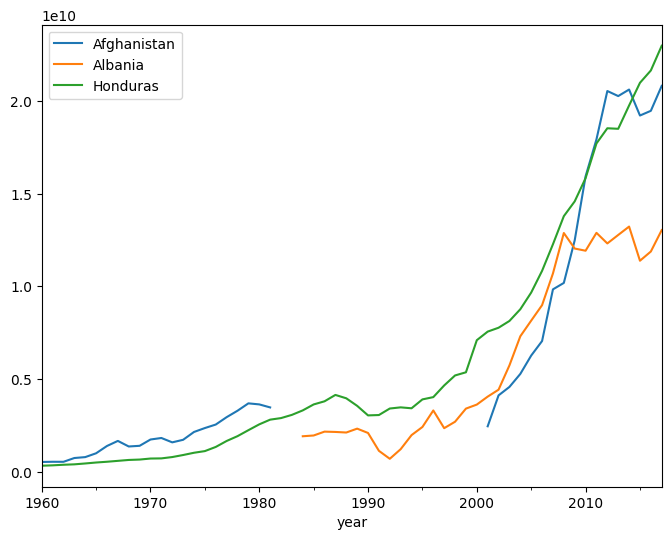

In [74]:
# Plot
%matplotlib inline

df_melt = pd.melt(df, id_vars=['Country Name', 'Country Code', 'Indicator Name',
                               'Indicator Code'], var_name='year',
                  value_name='GDP')

# convert year to date time
df_melt['year'] = pd.to_datetime(df_melt['year'])

def plot_results(column_name):
  # plotting result from Afghanistan, Albania, and Honduras
  fig, ax = plt.subplots(figsize=(8, 6))
  df_melt[(df_melt['Country Name'] == 'Afghanistan') | \
          (df_melt['Country Name'] == 'Albania') | \
          (df_melt['Country Name'] == 'Honduras')].groupby('Country Name') \
                                                  .plot('year',
                                                        column_name,
                                                        legend=True,
                                                        ax=ax)
  ax.legend(labels=['Afghanistan', 'Albania', 'Honduras'])

plot_results('GDP')

Missing data in Afghanistan and Albania show up as gaps in the results.

Part 1:
Calculating mean GDP for each country and fill in missing values with country mean.

In [75]:
'''
Using df_melt dataframe to fill in missing values with country mean gdp.
Putting results in new column: 'GDP_filled'
'''
df_melt['GDP_filled'] = df_melt.groupby('Country Name')['GDP'].transform(
    lambda x: x.fillna(x.mean()))

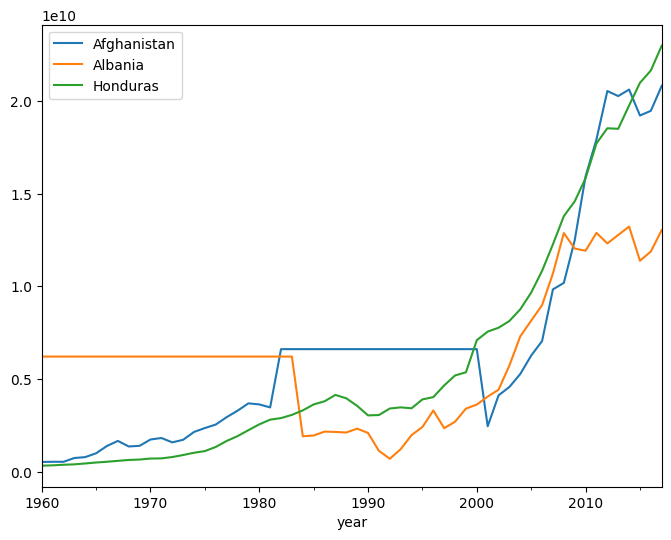

In [76]:
# Plot results
plot_results('GDP_filled')

Somewhat of an imporvement without missing data. However, GPD increases over time so the mean is probably not the best way to fillna.

Next We'll try forward fill.

Part 2 -
Using fillna to fill missing data.
1.   Make sure data is sorted by year.
2.   Group data by country name so forward fill stays within each country.



In [77]:
df_melt['GDP_ffill'] = df_melt.sort_values(
    'year').groupby(
        'Country Name')['GDP'].fillna(method='ffill')

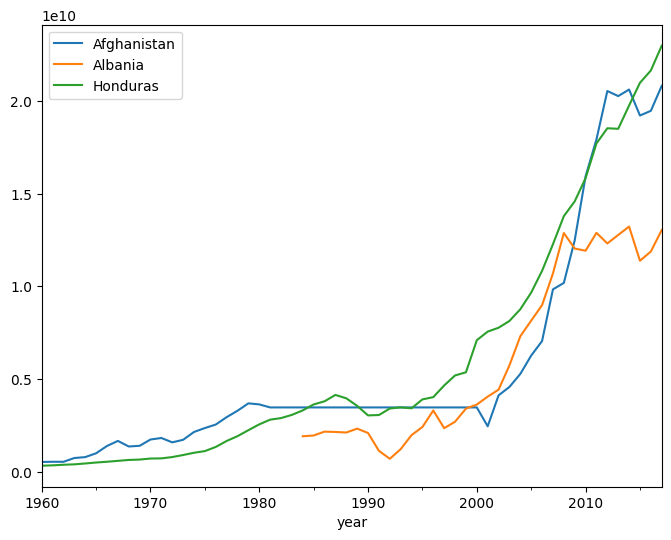

In [78]:
plot_results('GDP_ffill')

Afghanistan looks better. Albania still missing values. We'll use back fill for Albania.

Part 3 - Using backfill for missing GPD data.

In [79]:
df_melt['GDP_bfill'] = df_melt.sort_values(
    'year').groupby(
        'Country Name')['GDP'].fillna(method='bfill')

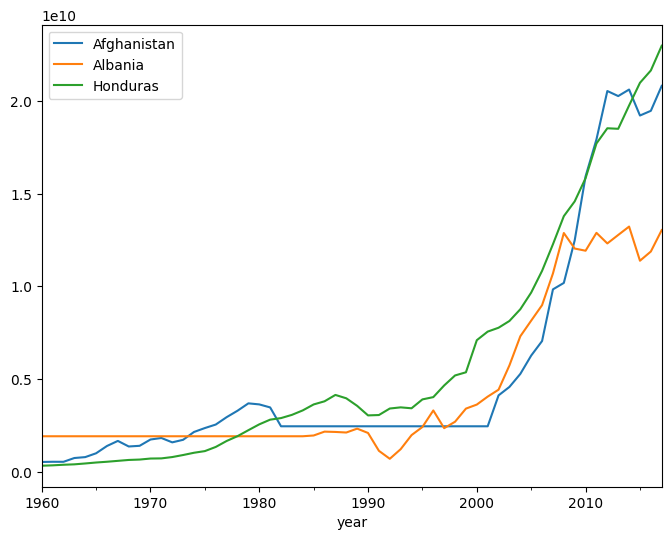

In [80]:
plot_results('GDP_bfill')

Note: forward fill did not fill all Albania data because first data entry in 1960 was NaN. Forward fill would try to fill the 1961 value with the NaN value from 1960.
We can try running both forward and back fill as the results will be slightly different depending on which one you run first.

For example: Afghanistan is missing data in the middle of the dataset.

In [81]:
# Runnning forward fill and backward fill on GDP data
df_melt['GDP_ff_bf'] = df_melt.sort_values(
    'year').groupby(
        'Country Name')['GDP'].fillna(method='ffill').fillna(method='bfill')

# Checking nulls in GDP values
df_melt['GDP_ff_bf'].isnull().sum()

0

**Duplicate Data**

From the World Bank GDP data, we'll count the number of countries that have had a project totalamt greater than 1 billion dollars. In order to get this count we'll have to remove duplicate data rows:

In [82]:
projects = pd.read_csv('projects_data.csv', dtype=str)
projects.drop('Unnamed: 56', axis=1, inplace=True)
projects['totalamt'] = pd.to_numeric(projects['totalamt'].str.replace(',',''))
projects['countryname'] = projects['countryname'].str.split(';', expand=True)[0]
projects['boardapprovaldate'] = pd.to_datetime(projects['boardapprovaldate'])

# filter the dataframe for projects over 1 billion dollars
projects[projects['totalamt'] > 1000000000]['countryname'].nunique()

17

**Dummy Variables**

Machine learning algorithms read in numbers not text. Text needs to be converted into numbers.

In [83]:
projects.columns

Index(['id', 'regionname', 'countryname', 'prodline', 'lendinginstr',
       'lendinginstrtype', 'envassesmentcategorycode', 'supplementprojectflg',
       'productlinetype', 'projectstatusdisplay', 'status', 'project_name',
       'boardapprovaldate', 'board_approval_month', 'closingdate',
       'lendprojectcost', 'ibrdcommamt', 'idacommamt', 'totalamt', 'grantamt',
       'borrower', 'impagency', 'url', 'projectdoc ', 'majorsector_percent ',
       'sector1', 'sector2', 'sector3', 'sector4', 'sector5', 'sector',
       'mjsector1', 'mjsector2', 'mjsector3', 'mjsector4', 'mjsector5',
       'mjsector', 'theme1', 'theme2', 'theme3', 'theme4', 'theme5', 'theme ',
       'goal', 'financier', 'mjtheme1name', 'mjtheme2name', 'mjtheme3name',
       'mjtheme4name', 'mjtheme5name', 'location', 'GeoLocID', 'GeoLocName',
       'Latitude', 'Longitude', 'Country'],
      dtype='object')

In [84]:
# keeping project name, lending, sector and theme data
sector = projects.copy()
sector = sector[[
    'project_name','lendinginstr','sector1','sector2','sector3','sector4',
    'sector5', 'sector','mjsector1','mjsector2','mjsector3','mjsector4',
    'mjsector5','mjsector','theme1','theme2','theme3','theme4','theme5',
    'theme ','goal','financier','mjtheme1name','mjtheme2name','mjtheme3name',
    'mjtheme4name','mjtheme5name']]

In [85]:
# percentage of each variable that is null
100 * sector.isnull().sum() / sector.shape[0]

project_name      0.000000
lendinginstr      1.348093
sector1           0.000000
sector2          47.791539
sector3          64.450899
sector4          76.019290
sector5          85.132617
sector            3.496274
mjsector1       100.000000
mjsector2       100.000000
mjsector3       100.000000
mjsector4       100.000000
mjsector5       100.000000
mjsector          3.496274
theme1            0.000000
theme2           46.005042
theme3           58.987286
theme4           71.317405
theme5           83.954406
theme           100.000000
goal             33.510522
financier        61.310829
mjtheme1name    100.000000
mjtheme2name    100.000000
mjtheme3name    100.000000
mjtheme4name    100.000000
mjtheme5name    100.000000
dtype: float64

mjsector1 - 5 are all null and mjthemename1 - 5 are all null. They propably are not useful.

sector1 seems promising with 0 null values.

In [86]:
# Store unique sector 1 values in a list
uniquesectors1 = sector['sector1'].sort_values().unique()
# uniquesectors1

print('Number of unique values in sector1: ', len(uniquesectors1))

Number of unique values in sector1:  3060


 there are values labeled '!$!0' in sector1. These should be substituted with NaN.
 Each sector1 value ends with a ten or eleven character string like '! !49!
 !EP'. Some sectors show up twice in the list like: 'Other Industry; Trade and Services! !70!
 !YZ', 'Other Industry; Trade and Services! !63!
 !YZ',

 We'll remove everything past the exclamation point. Many values in the sector1 variable start with the term '(Historic)'. We'll try removing that phrase as well.




**replace() method** & **[regular expression](https://en.wikipedia.org/wiki/Regular_expression)**

The replace method can take a regular expression.

*[regular expression chear sheet](https://medium.com/factory-mind/regex-tutorial-a-simple-cheatsheet-by-examples-649dc1c3f285)*

In [87]:
# replaceing the string '!$!0' with nan in sector1 variable
sector['sector1'] = sector['sector1'].replace('!$!0', np.nan)

# removing the last 10 or 11 characters from sector1 variable
sector['sector1'] = sector['sector1'].replace('!.+','', regex=True)

# removing the string (Historic) from the sector1 variable
sector['sector1'] = sector['sector1'].replace('^(\(Historic\))', '', regex=True)

print('Number of unique sectors after cleaning: ', len(
    list(sector['sector1'].unique())))
print('Percentage of null values after cleaning: ', 100 * sector['sector1'] .isnull().sum() / sector['sector1'].shape[0])

Number of unique sectors after cleaning:  156
Percentage of null values after cleaning:  3.4962735642262164


156 unique categorical variables is better than 3060. We'll try converting these 156 values to dummy variables for our supervised machine learning model.

We'll have to train and test a model to see if these are good features.

Using the pandas pd.get_dummies() method to create dummy variables. Then we'll use the concat() method to concatenate the dummy variables to a dataframe that contains the project totalamt variable and the project year from the boardapprovaldate.

In [88]:
dummies = pd.DataFrame(pd.get_dummies(sector['sector1']))
'''
Filtering the project data for totalamt, year from boardapprovaldate,
and dummy variables.
'''
projects['year'] = projects['boardapprovaldate'].dt.year
df = projects[['totalamt','year']]
df_final = pd.concat([df, dummies], axis=1)

df_final.head()


,totalamt,year,Adult; Basic and Continuing Education,Agency reform,Agricultural Extension; Research; and Other Support Activities,Agricultural credit,Agricultural extension,Agricultural markets; commercialization and agri-business,Agriculture adjustment,Agro-industry,...,Urban environment,Urban housing,Urban management,Urban transport,Urban water supply,Vocational training,Waste Management,Water Supply,Water supply and sanitation adjustment,Workforce Development and Vocational Education
0,0,2018.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,200000000,2018.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,58330000,2018.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20000000,2018.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,100000000,2018.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Finding Outliers**

In [89]:
# Doing some basic wrangilng with projects data
gdp = pd.read_csv('gdp_data.csv', skiprows=4)
gdp.drop(['Unnamed: 62', 'Country Code', 'Indicator Name', 'Indicator Code'],
          inplace=True, axis=1)
population = pd.read_csv('population_data.csv', skiprows=4)
population.drop(['Unnamed: 62', 'Country Code', 'Indicator Name',
                 'Indicator Code'], inplace=True, axis=1)

# Reshape datasets into long format
gdp_melt = gdp.melt(id_vars=['Country Name'], var_name='year', value_name='gdp')

# Using back fill and forward fill to fill missing gpd values
gdp_melt['gdp'] = gdp_melt.sort_values('year').groupby('Country Name')['gdp'] \
                                              .fillna(method='ffill') \
                                              .fillna(method='bfill')
population_melt = population.melt(id_vars=['Country Name'],
                                  var_name='year',
                                  value_name='population')

# Using back fill and forward fill to fill missing population values
population_melt['population'] = population_melt.sort_values('year') \
                                  .groupby('Country Name')['population'] \
                                  .fillna(method='ffill') \
                                  .fillna(method='bfill')

# merge the population and gdp data together
df_country = gdp_melt.merge(population_melt, on=('Country Name', 'year'))

# filter data for year 2016
df_2016 = df_country[df_country['year'] == '2016']

df_2016.head()


,Country Name,year,gdp,population
14784,Aruba,2016,2.584464e+09,104822.0
14785,Afghanistan,2016,1.946902e+10,34656032.0
14786,Angola,2016,9.533720e+10,28813463.0
14787,Albania,2016,1.188368e+10,2876101.0
14788,Andorra,2016,2.877312e+09,77281.0


Identify outliers using the Tukey rule.

<Axes: >

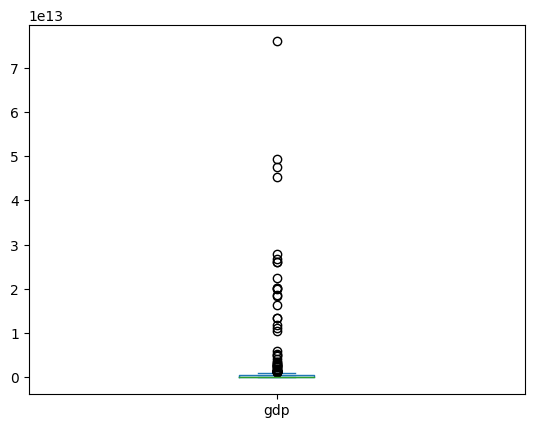

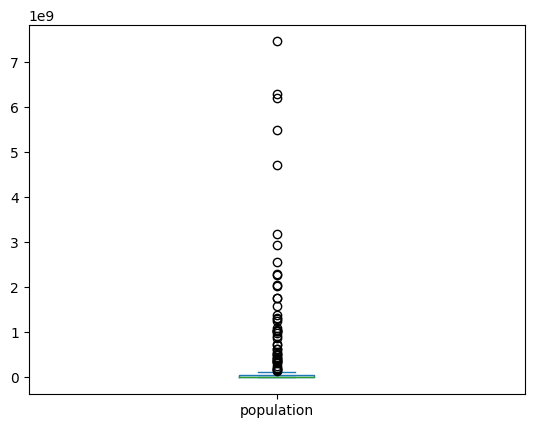

In [90]:
%matplotlib inline

# boxplt of population data year 2016
df_2016.plot('population', kind='box')

# boxplot of gpd data year 2016
df_2016.plot('gdp', kind='box')

Using the Turkey Rule (Using one dimension) to determine what values of the population data are outliers of the year 2016:



*   Find the first quartile (.25th quartile)
*   Find the third quartile (.75th quartile)
*   Calculate the inter-quartile range (Q3 - Q1)
*   Any value greater than Q3 + 1.5 * IQR is an outlier
*   Any value that is less than Q1 - 1.5 * IQR is an outlier



In [91]:
population_2016 = df_2016[['Country Name', 'population']]

# First Quartile values
Q1 = population_2016['population'].quantile(0.25)

# Third Quantile
Q3 = population_2016['population'].quantile(0.75)

# Interquartile
IQR = Q3 - Q1

# Max and Min values
max_values = Q3 + 1.5 * IQR
min_values = Q1 - 1.5 * IQR

'''
Filter population 2016 data for population values that are greater than
max values or less than min values
'''
population_outliers = population_2016[(
    population_2016['population'] > max_values) | (
        population_2016['population'] > min_values)]
population_outliers

,Country Name,population
14784,Aruba,104822.0
14785,Afghanistan,34656032.0
14786,Angola,28813463.0
14787,Albania,2876101.0
14788,Andorra,77281.0
...,...,...
15043,Kosovo,1816200.0
15044,"Yemen, Rep.",27584213.0
15045,South Africa,56015473.0
15046,Zambia,16591390.0


It appears many of these outliers are due to the regional data being aggregated together.

We'll  be removing these data points and redoing the analysis.

There's a list provided below of the 'Country Name' values that are not actually countries.

In [92]:
non_countries = [
    'World', 'High income', 'OECD members', 'Post-demographic dividend',
    'IDS & IBRD total', 'Low & middle income', 'Middle income', 'IBRD only',
    'East Asian & Pacific', 'Europe & Central Asia','North America',
    'Upper middle income', 'Late-demographic dividend', 'Eurpoean Union',
    'East Asia & Pacific (excluding high income)',
    'East Asia & Pacific (IDA & IBRD countries)','Euro area',
    'Early-demographic dividend','Lower middle income',
    'Latin America & Caribbean',
    'Latin America & the Caribbean (IDA & IBRD countries)',
    'Latin America & Caribbean (excluding high income)',
    'Europe & Central Asia (IDA & IBRD countries)','Middle East & North Africa',
    'Europe & Central Asia (excluding high income)','South Asia (IDA & IBRD)',
    'South Asia','Arab World','IDA total', 'Sub-Saharan Africa',
    'Sub-Saharan Africa (IDA & IBRD countries)',
    'Sub-Saharan Africa (excluding high income)',
    'Middle East & North Africa (excluding high income)',
    'Middle East & North Africa (IDA & IBRD countries)',
    'Central Europe and the Baltics','Pre-demographic dividend','IDA only',
    'Least developed countries: UN classification','IDA blend',
    'Fragile and conflict affected situations',
    'Heavily indebted poor countries (HIPC)','Low income','Small states',
    'Other small states','Not classified', 'Carribean small states',
    'Pacific island small states']

# removing non-countries from the data
df_2016 = df_2016[~df_2016['Country Name'].isin(non_countries)]

In [93]:
# Re-run the Turkey Code

population_2016 = df_2016[['Country Name', 'population']]

# First Quartile values
Q1 = population_2016['population'].quantile(0.25)

# Third Quantile
Q3 = population_2016['population'].quantile(0.75)

# Interquartile
IQR = Q3 - Q1

# Max and Min values
max_values = Q3 + 1.5 * IQR
min_values = Q1 - 1.5 * IQR

'''
Filter population 2016 data for population values that are greater than
max values or less than min values
'''
population_outliers = population_2016[(
    population_2016['population'] > max_values) | (
        population_2016['population'] > min_values)]
population_outliers


,Country Name,population
14784,Aruba,104822.0
14785,Afghanistan,34656032.0
14786,Angola,28813463.0
14787,Albania,2876101.0
14788,Andorra,77281.0
...,...,...
15043,Kosovo,1816200.0
15044,"Yemen, Rep.",27584213.0
15045,South Africa,56015473.0
15046,Zambia,16591390.0


In [94]:
gdp_2016 = df_2016[['Country Name', 'gdp']]

# First Quartile values
Q1 = gdp_2016['gdp'].quantile(0.25)

# Third Quantile
Q3 = gdp_2016['gdp'].quantile(0.75)

# Interquartile
IQR = Q3 - Q1

# Max and Min values
max_values = Q3 + 1.5 * IQR
min_values = Q1 - 1.5 * IQR

'''
Filter population 2016 data for population values that are greater than
max values or less than min values
'''
gdp_outliers = population_2016[(
    gdp_2016['gdp'] > max_values) | (
        gdp_2016['gdp'] > min_values)]
gdp_outliers

,Country Name,population
14784,Aruba,104822.0
14785,Afghanistan,34656032.0
14786,Angola,28813463.0
14787,Albania,2876101.0
14788,Andorra,77281.0
...,...,...
15043,Kosovo,1816200.0
15044,"Yemen, Rep.",27584213.0
15045,South Africa,56015473.0
15046,Zambia,16591390.0


In [95]:
# Finding country names that are in both the population_outliers and gdp_outliers

list(set(
    population_outliers['Country Name']).intersection(
        gdp_outliers['Country Name']))

['Afghanistan',
 'Angola',
 'Turks and Caicos Islands',
 'Trinidad and Tobago',
 'Peru',
 'Belgium',
 'Nigeria',
 'Samoa',
 'Nicaragua',
 'Greece',
 'Malta',
 'Burkina Faso',
 'Japan',
 'Mexico',
 'Uzbekistan',
 'Niger',
 'Turkey',
 'United Arab Emirates',
 'Papua New Guinea',
 'Luxembourg',
 'Bangladesh',
 'Bolivia',
 'Greenland',
 'Madagascar',
 'Vanuatu',
 'Isle of Man',
 'Sint Maarten (Dutch part)',
 'Zimbabwe',
 'South Sudan',
 'Singapore',
 'Ecuador',
 'Tunisia',
 'Denmark',
 'Cambodia',
 'Bahamas, The',
 'Guyana',
 'Qatar',
 'St. Martin (French part)',
 'Fiji',
 'Lesotho',
 'Serbia',
 'Croatia',
 'Senegal',
 'Djibouti',
 'Belize',
 'Guatemala',
 'Kuwait',
 'Armenia',
 'Guam',
 'Montenegro',
 'Turkmenistan',
 'Tuvalu',
 'Benin',
 'Guinea',
 'Bosnia and Herzegovina',
 'Uruguay',
 'Slovak Republic',
 'Moldova',
 'Suriname',
 'IDA & IBRD total',
 'Andorra',
 'Cayman Islands',
 'St. Lucia',
 'Venezuela, RB',
 'Nauru',
 'Spain',
 'Northern Mariana Islands',
 'Malaysia',
 'Burundi',
 '

These countries have both relatively high populations and high GDPs. That might be an indication that although these countries have high values for both gdp and population, they're not true outliers when looking at these values from a two-dimensional perspective.

In [96]:
'''
Finding country names that are in the population
oultiers list but NOT in the gdp list
'''
list(set(population_outliers['Country Name']) - set(gdp_outliers['Country Name']))

[]

In [97]:
list(set(gdp_outliers['Country Name']) - set(population_outliers['Country Name']))

[]

**2-Dimensional Analysis**

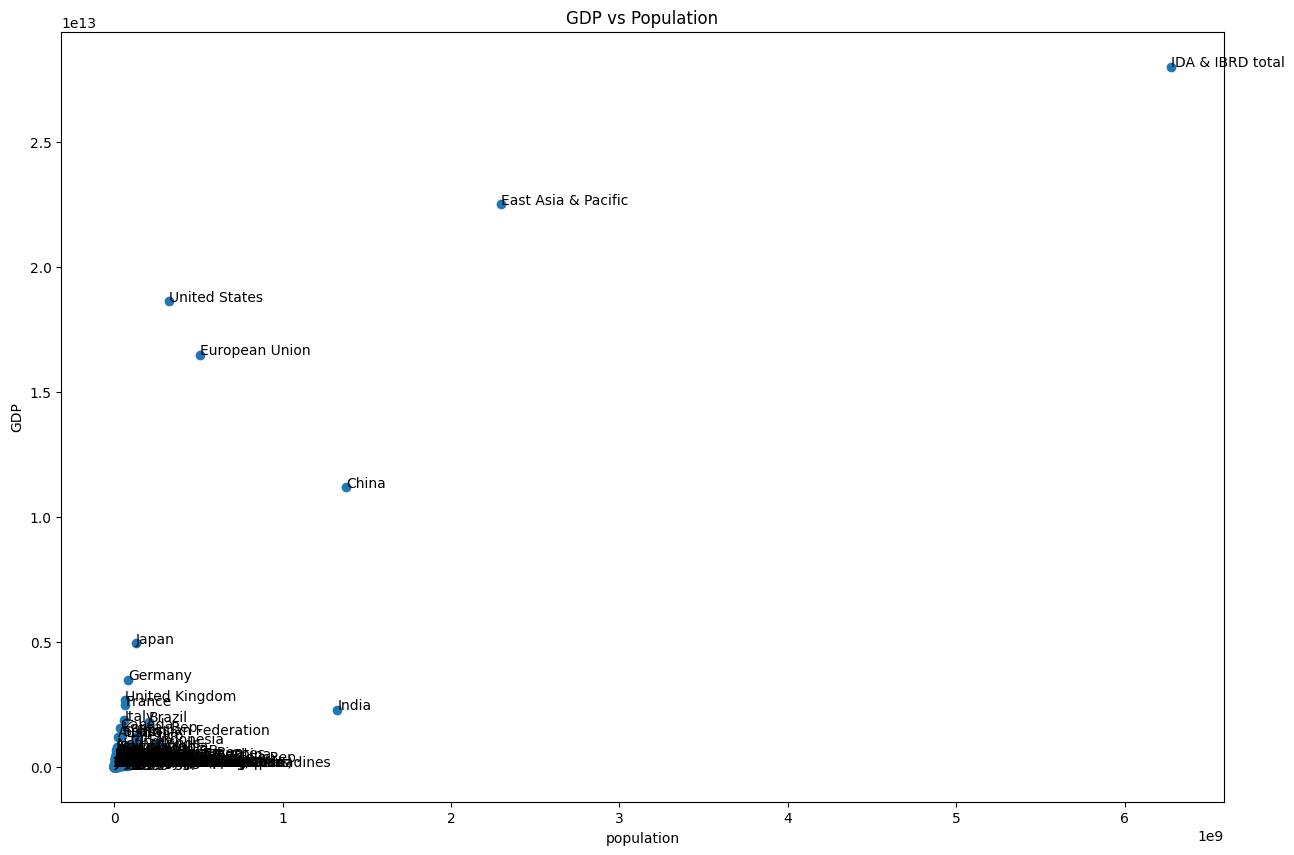

In [98]:
x = list(df_2016['population'])
y = list(df_2016['gdp'])
text = df_2016['Country Name']

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x, y)
plt.title('GDP vs Population')
plt.xlabel('population')
plt.ylabel('GDP')
for i, txt in enumerate(text):
  ax.annotate(txt, (x[i], y[i]))

Relative to The US, China, and India, the rest of the data points are insignificant. Making this data hard to visualize.

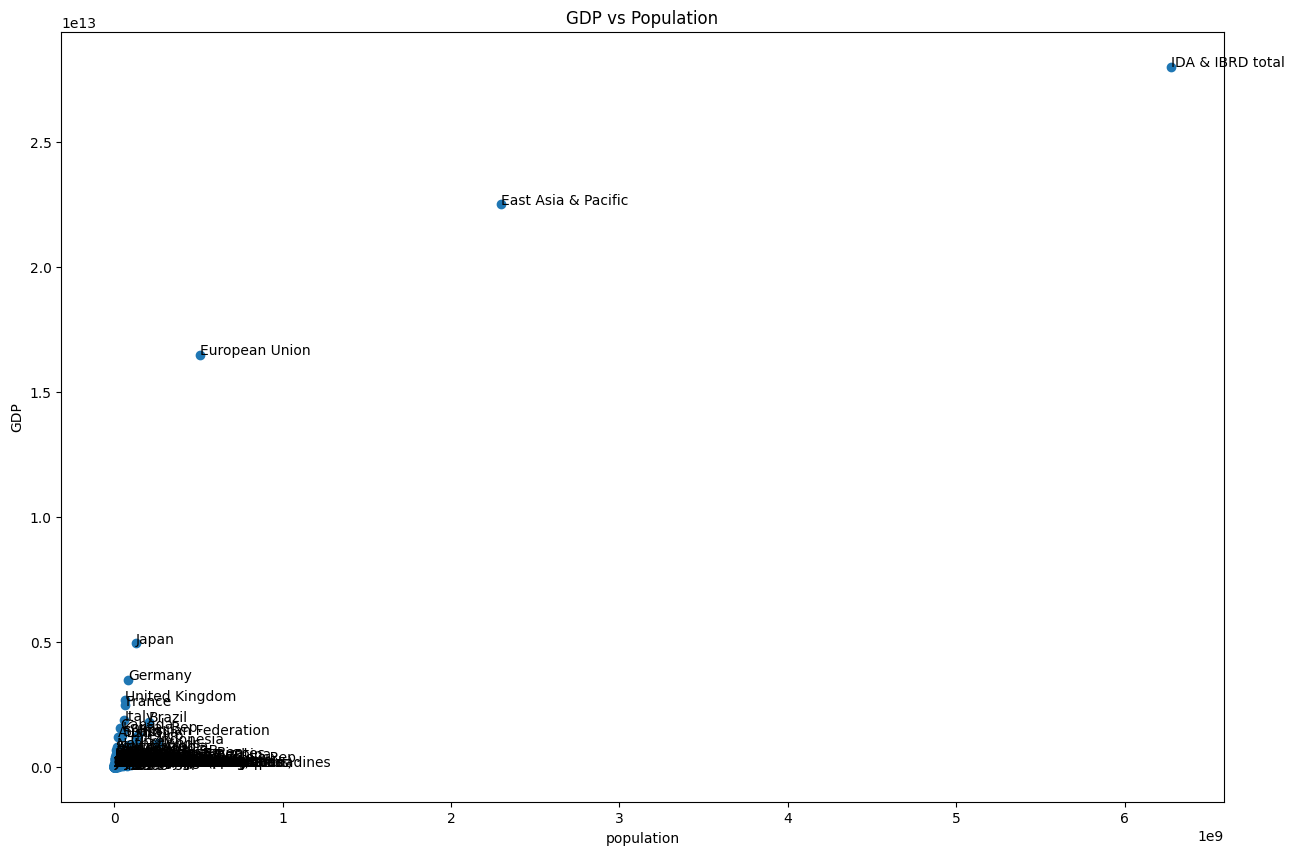

In [99]:
# Removing the top 3 countries and reevaluating
df_no_large = (
    df_2016['Country Name'] != 'United States') & (
        df_2016['Country Name'] != 'India') & (
            df_2016['Country Name'] != 'China')

x = list(df_2016[df_no_large]['population'])
y = list(df_2016[df_no_large]['gdp'])
text = df_2016[df_no_large]['Country Name']

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x, y)
plt.title('GDP vs Population')
plt.xlabel('population')
plt.ylabel('GDP')
for i, txt in enumerate(text):
  ax.annotate(txt, (x[i], y[i]))



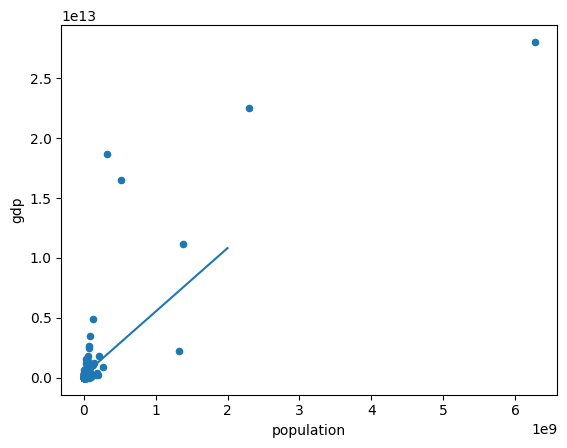

In [100]:
# Import sklinear_model Linear Regression (Import Cell Above)

 # fit a linear regression model on the population and gdp data

model = LinearRegression()
model.fit(df_2016['population'].values.reshape(-1, 1),
          df_2016['gdp'].values.reshape(-1, 1))

# plot data with predictions
inputs = np.linspace(1, 2000000000, num=50)
predictions = model.predict(inputs.reshape(-1, 1))

df_2016.plot('population', 'gdp', kind='scatter')
plt.plot(inputs, predictions)

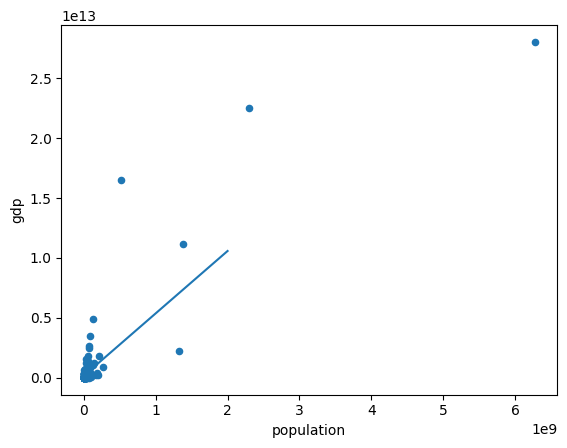

In [101]:
# Removing the US
df_2016[df_2016['Country Name'] != 'United States'].plot(
    'population', 'gdp', kind='scatter')
model.fit(df_2016[df_2016['Country Name'] != 'United States']['population'].values.reshape(-1, 1),
          df_2016[df_2016['Country Name'] != 'United States']['gdp'].values.reshape(-1, 1))
inputs = np.linspace(1, 2000000000, num=50)
predictions = model.predict(inputs.reshape(-1, 1))
plt.plot(inputs, predictions)


In [102]:
df_2016.columns

Index(['Country Name', 'year', 'gdp', 'population'], dtype='object')

In [103]:
# Doing some basic wrangilng with projects data
gdp = pd.read_csv('gdp_data.csv', skiprows=4)
gdp.drop(['Unnamed: 62', 'Country Code', 'Indicator Name', 'Indicator Code'],
          inplace=True, axis=1)
population = pd.read_csv('population_data.csv', skiprows=4)
population.drop(['Unnamed: 62', 'Country Code', 'Indicator Name',
                 'Indicator Code'], inplace=True, axis=1)

# Reshape datasets into long format
gdp_melt = gdp.melt(id_vars=['Country Name'], var_name='year', value_name='gdp')

# Using back fill and forward fill to fill missing gpd values
gdp_melt['gdp'] = gdp_melt.sort_values('year').groupby('Country Name')['gdp'] \
                                              .fillna(method='ffill') \
                                              .fillna(method='bfill')
population_melt = population.melt(id_vars=['Country Name'],
                                  var_name='year',
                                  value_name='population')

# Using back fill and forward fill to fill missing population values
population_melt['population'] = population_melt.sort_values('year') \
                                  .groupby('Country Name')['population'] \
                                  .fillna(method='ffill') \
                                  .fillna(method='bfill')

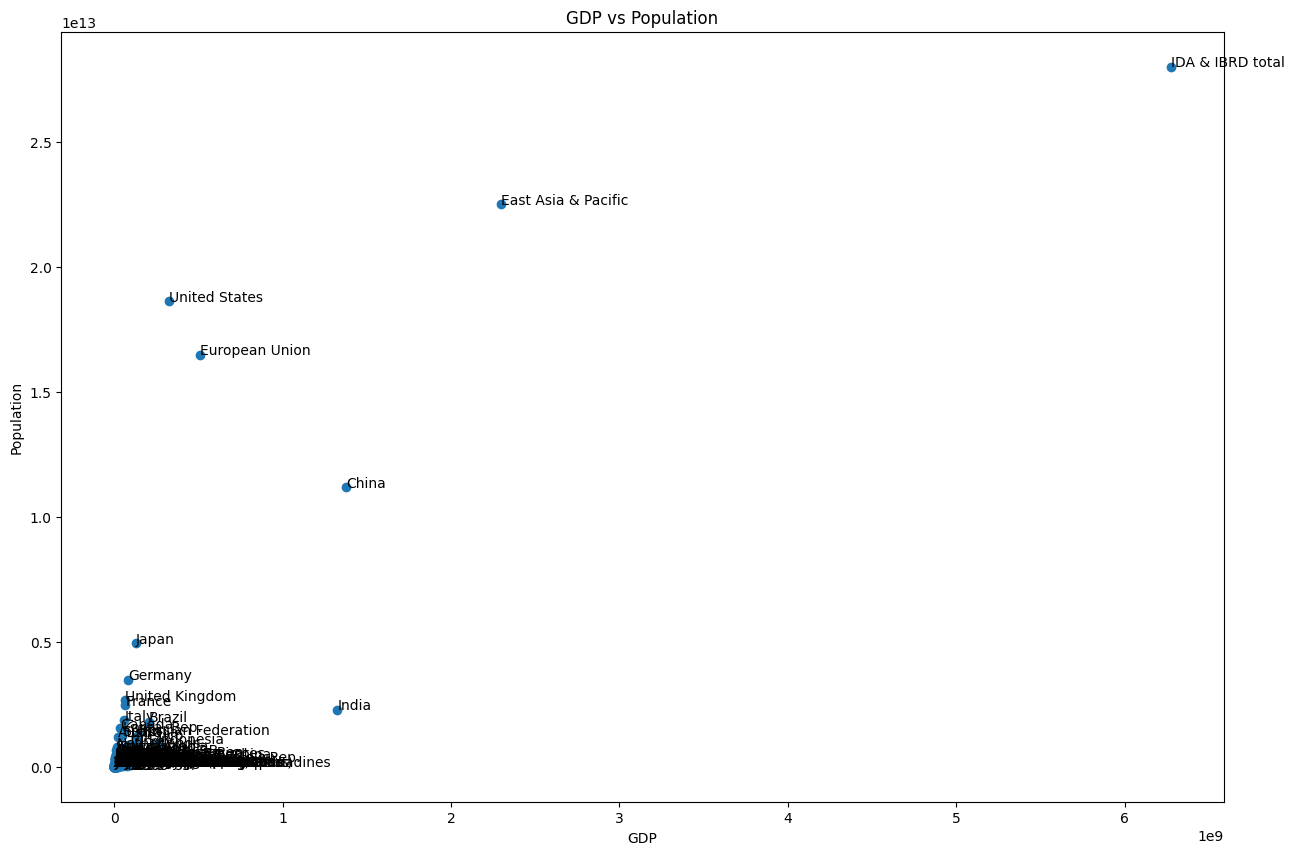

In [104]:
%matplotlib inline

# merging two data sets
df_country = gdp_melt.merge(population_melt, on=('Country Name', 'year'))

# filter data for 2016
df_2016 = df_country[df_country['year'] == '2016']

# remove non countries
df_2016 = df_2016[~df_2016['Country Name'].isin(non_countries)]

# plot
x = list(df_2016['population'])
y = list(df_2016['gdp'])
text = df_2016['Country Name']

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x, y)
plt.title('GDP vs Population')
plt.xlabel('GDP')
plt.ylabel('Population')
for i, txt in enumerate(text):
    ax.annotate(txt, (x[i],y[i]))



Eliminating Outliers

In [105]:
'''
A function that uses the Turkey Rule to detect outliers in a dataframe column
then removed that entire row from the data frame.

The functions inputs should be:
 - A data frame
 - A column name

The functions outputs should be:
 - A data frame with the outliers eliminated
'''

def tukey_rule(data_frame, column_name):
    data = data_frame[column_name]
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    IQR = Q3 - Q1

    max_value = Q3 + 1.5 * IQR
    min_value = Q1 - 1.5 * IQR

    return data_frame[(data_frame[column_name] < max_value) & (data_frame[column_name] > min_value)]


In [106]:
df_outlier_removed = df_2016.copy()

for column in ['population', 'gdp']:
  df_outlier_removed = tukey_rule(df_outlier_removed, column)

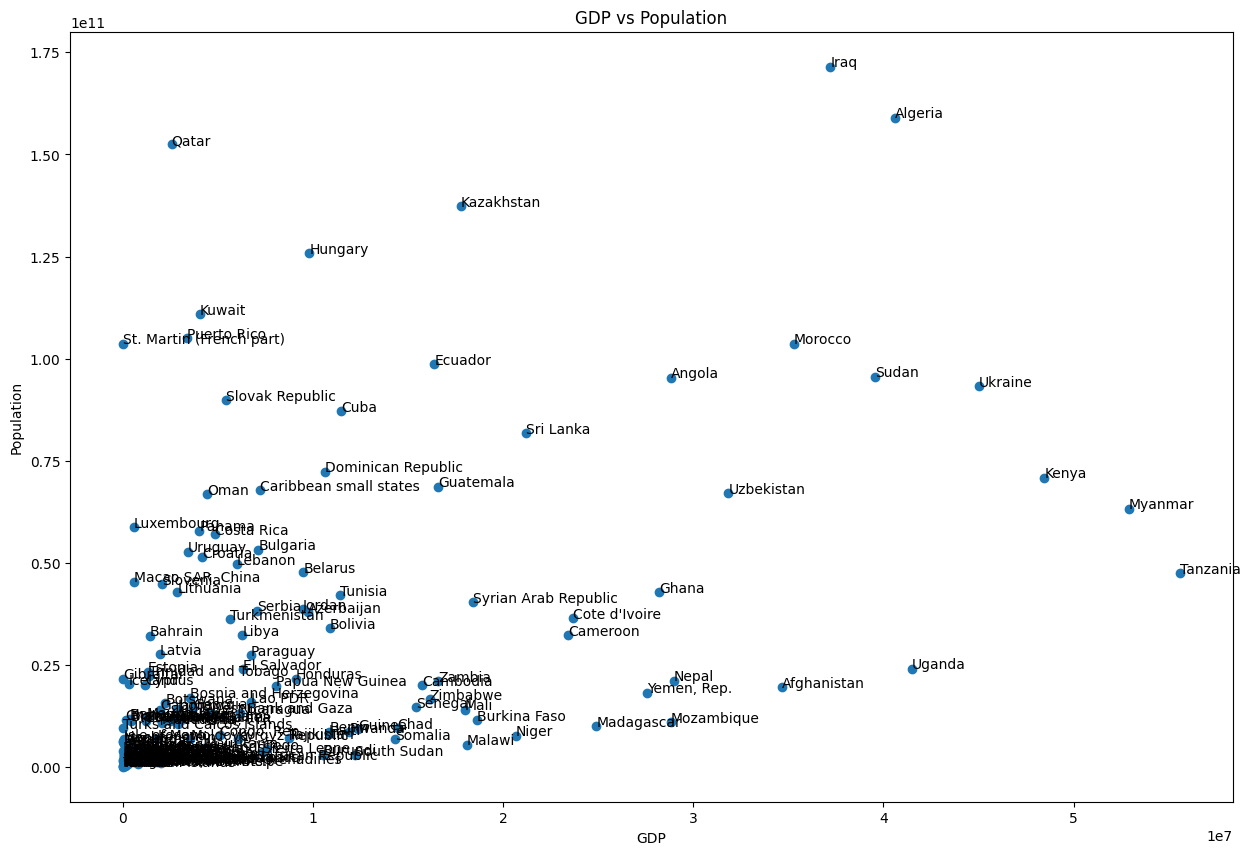

In [107]:
# plot
x = list(df_outlier_removed['population'])
y = list(df_outlier_removed['gdp'])
text = df_outlier_removed['Country Name']

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x, y)
plt.title('GDP vs Population')
plt.xlabel('GDP')
plt.ylabel('Population')
for i, txt in enumerate(text):
    ax.annotate(txt, (x[i],y[i]))

Scaling Data

 Standardization refers to scaling a set of values so that they have a mean of zero and a standard deviation of one. Normalization refers to scaling a set of values so that the range if between zero and one.

 There are libraries, like scikit-learn, that can do this for you; however, in data engineering, you might not always have these tools available.

In [108]:
gdp = pd.read_csv('gdp_data.csv', skiprows=4)
gdp.drop(['Unnamed: 62', 'Country Code', 'Indicator Name', 'Indicator Code'],
         inplace=True, axis=1)
population = pd.read_csv('population_data.csv', skiprows=4)
population.drop(['Unnamed: 62', 'Country Code', 'Indicator Name',
                 'Indicator Code'], inplace=True, axis=1)

# Reshape datasets into long format
gdp_melt = gdp.melt(id_vars=['Country Name'], var_name='year', value_name='gdp')

# Using back fill and forward fill to fill missing gpd values
gdp_melt['gdp'] = gdp_melt.sort_values('year').groupby('Country Name')['gdp'] \
                                              .fillna(method='ffill') \
                                              .fillna(method='bfill')
population_melt = population.melt(id_vars=['Country Name'],
                                  var_name='year',
                                  value_name='population')

# Using back fill and forward fill to fill missing population values
population_melt['population'] = population_melt.sort_values('year') \
                                  .groupby('Country Name')['population'] \
                                  .fillna(method='ffill') \
                                  .fillna(method='bfill')

# merging two data sets
df_country = gdp_melt.merge(population_melt, on=('Country Name', 'year'))

# filter data for 2016
df_2016 = df_country[df_country['year'] == '2016']

# remove non countries
df_2016 = df_2016[~df_2016['Country Name'].isin(non_countries)]

print('first ten rows of data :', df_2016.head())

first ten rows of data :       Country Name  year           gdp  population
14784        Aruba  2016  2.584464e+09    104822.0
14785  Afghanistan  2016  1.946902e+10  34656032.0
14786       Angola  2016  9.533720e+10  28813463.0
14787      Albania  2016  1.188368e+10   2876101.0
14788      Andorra  2016  2.877312e+09     77281.0


In [109]:
df_2016.columns

Index(['Country Name', 'year', 'gdp', 'population'], dtype='object')

Normalize Data:

To normalize data, you take a feature, like gdp, and use the following formula

xnormalized=x−xminx / xmax−xmin

where

* x is a value of gdp
* x_max is the maximum gdp in the data
* x_min is the minimum GDP in the data

First, write a function that outputs the x_min and x_max values of an array. The inputs are an array of data (like the GDP data). The outputs are the x_min and x_max values

In [110]:
'''
x_min_max:
  - A function that returns the minimum and maximum of the GDP dataset
'''

def x_min_max(data):
  minimum = min(data)
  maximum = max(data)
  return minimum, maximum

x_min_max(df_2016['gdp'])

(36572611.8853148, 28005663818401.1)

In [111]:
def normalize(x_min, x_max):
  # The input is a single value
  # The output is the normalized value
  return(x- x-min) / (x_max - x_min)

In [112]:
class Normalizer():
  '''
  The normalizer class recieves a dataframe as its only input for initialization.
    - ie... the data frame might contain gdp and poulation data in two seperate
  columns
  '''
  def __init__(self, dataframe):
    '''
    Iterating through each column calculating the min and max for each column,
    apped the results to the params attribute listed.
    '''
    self.params = []
    for column in dataframe.columns:
      self.params.append(x_min_max(dataframe[column]))

  def x_min_max(data):
    minimum = min(data)
    maximum = max(data)
    return minimum, maximum

  def normalize_data(self, x):
    '''
    This function recieves a data point as an input and then outputs
    the normalized version
    '''
    normalized = []
    for i, value in enumerate(x):
      x_max = self.params[i][1]
      x_min = self.params[i][0]
      normalized.append((x[i] - x_min) / (x_max - x_min))
      return normalized

In [113]:
gdp_normalizer = Normalizer(df_2016[['gdp', 'population']])

In [114]:
gdp_normalizer.params

[(36572611.8853148, 28005663818401.1), (11097.0, 6273584648.0)]

In [115]:
gdp_normalizer.normalize_data([13424475000000.0, 1300000000])

[0.4793478935347376]

When normalizing or standardizing features for machine learning, you'll need to store the parameters you used to do the scaling. That way you can scale new data points when making predictions.

When standardizing data, you would need to store the mean and standard deviation. The standardization formula is:

xstandardized=x−x/S

**Feature Engineering**

In [116]:
# Doing some basic wrangilng with projects data
gdp = pd.read_csv('gdp_data.csv', skiprows=4)
gdp.drop(['Unnamed: 62', 'Country Code', 'Indicator Name', 'Indicator Code'],
          inplace=True, axis=1)
population = pd.read_csv('population_data.csv', skiprows=4)
population.drop(['Unnamed: 62', 'Country Code', 'Indicator Name',
                 'Indicator Code'], inplace=True, axis=1)

# Reshape datasets into long format
gdp_melt = gdp.melt(id_vars=['Country Name'], var_name='year', value_name='gdp')

# Using back fill and forward fill to fill missing gpd values
gdp_melt['gdp'] = gdp_melt.sort_values('year').groupby('Country Name')['gdp'] \
                                              .fillna(method='ffill') \
                                              .fillna(method='bfill')
population_melt = population.melt(id_vars=['Country Name'],
                                  var_name='year',
                                  value_name='population')

# Using back fill and forward fill to fill missing population values
population_melt['population'] = population_melt.sort_values('year') \
                                  .groupby('Country Name')['population'] \
                                  .fillna(method='ffill') \
                                  .fillna(method='bfill')

# merge the population and gdp data together into one data frame
df_country = gdp_melt.merge(population_melt, on=('Country Name', 'year'))

# filter data for the year 2016
df_2016 = df_country[df_country['year'] == '2016']

# remove non countries from the data
df_2016 = df_2016[~df_2016['Country Name'].isin(non_countries)]
df_2016.reset_index(inplace=True, drop=True)

In [117]:
df_2016.columns

Index(['Country Name', 'year', 'gdp', 'population'], dtype='object')

In [118]:
# Creating new feature 'gdppercapita, gdp divided by population for each country
df_2016['gdppercapita'] = df_2016['gdp'] / df_2016['population']

**Load**

In [129]:
# Doing some basic wrangilng with projects data
gdp = pd.read_csv('gdp_data.csv', skiprows=4)
gdp.drop(['Unnamed: 62', 'Indicator Name', 'Indicator Code'],
          inplace=True, axis=1)
population = pd.read_csv('population_data.csv', skiprows=4)
population.drop(['Unnamed: 62', 'Indicator Name',
                 'Indicator Code'], inplace=True, axis=1)

# Reshape gdp dataset into long format
gdp_melt = gdp.melt(id_vars=['Country Name', 'Country Code'],
                    var_name='year',
                    value_name='gdp')
# Using back fill and forward fill to fill missing gpd values
gdp_melt['gdp'] = gdp_melt.sort_values('year').groupby(
    ['Country Name', 'Country Code'])['gdp'].fillna(
        method='ffill').fillna(method='bfill')
# Reshape population dataset into long format
population_melt = population.melt(id_vars=['Country Name','Country Code'],
                                  var_name='year',
                                  value_name='population')
# Using back fill and forward fill to fill missing population values
population_melt['population'] = population_melt.sort_values('year') \
                                  .groupby('Country Name')['population'] \
                                  .fillna(method='ffill') \
                                  .fillna(method='bfill')

# Merge the population and gdp data together into one dataframe
df_indicator = gdp_melt.merge(population_melt, on=('Country Name',
                                                   'Country Code',
                                                   'year'))

In [124]:
df_indicator_dupes = df_indicator.duplicated().sum()
print('The number of duplicates in the df_indicator dataset are: ', df_indicator_dupes)

gdp_dupes = gdp_melt.duplicated().sum()
print('The number of duplicates in the gdp_melt dataset are: ', gdp_dupes)

The number of duplicates in the df_indicator dataset are:  0
The number of duplicates in the gdp_melt dataset are:  0


In [125]:
df_indicator['Country Code']

0      ABW
1      AFG
2      AGO
3      ALB
4      AND
      ... 
259    XKX
260    YEM
261    ZAF
262    ZMB
263    ZWE
Name: Country Code, Length: 264, dtype: object

In [130]:
df_indicator  = df_indicator[~df_indicator['Country Name'].isin(non_countries)]
df_indicator.reset_index(inplace=True, drop=True)

df_indicator.columns = ['countryname', 'countrycode', 'year', 'gdp', 'population']

df_indicator.head()

,countryname,countrycode,year,gdp,population
0,Aruba,ABW,1960,1.916242e+09,54211.0
1,Afghanistan,AFG,1960,5.377778e+08,8996351.0
2,Angola,AGO,1960,1.857319e+10,5643182.0
3,Albania,ALB,1960,1.857319e+10,1608800.0
4,Andorra,AND,1960,1.857319e+10,13411.0


 This will create a data frame called df_projects containing the World Bank projects data:

In [135]:
# Import pycountry countries

df_projects = pd.read_csv('projects_data.csv', dtype=str)
df_projects.drop(['Unnamed: 56'], axis=1, inplace=True)

df_projects['countryname'] = df_projects['countryname'].str.split(';').str.get(0)

# setting up variables
country_not_found = []
project_country_abbrev_dict = defaultdict(str)

# iterating through country names in df_projects
# creating dictionary mapping the country name to correct Alpha_3 ISO code
for country in df_projects['countryname'].drop_duplicates().sort_values():
  try:
    project_country_abbrev_dict[country] = countries.lookup(country).alpha_3
  except:
    '''
    If country name is not in pycountry library then print out country name,
    and store the results in the country_not_found list.
    '''
    country_not_found.append(country)

project_country_abbrev_dict.update(country_not_found_mapping)

df_projects['countrycode'] = df_projects['countryname'].apply(
    lambda x: project_country_abbrev_dict[x])
df_projects['boardapprovaldate'] = pd.to_datetime(
    df_projects['boardapprovaldate'])
df_projects['year'] = df_projects['boardapprovaldate'].dt.year.astype(
    str).str.slice(stop=4)
df_projects['totalamt'] = pd.to_numeric(
    df_projects['totalamt'].str.replace(',',""))
df_projects = df_projects[['id','countryname','countrycode','totalamt','year']]

df_projects.head()

,id,countryname,countrycode,totalamt,year
0,P162228,World,WLD,0,2018
1,P163962,Democratic Republic of the Congo,,200000000,2018
2,P167672,People's Republic of Bangladesh,BGD,58330000,2018
3,P158768,Islamic Republic of Afghanistan,,20000000,2018
4,P161364,Federal Republic of Nigeria,NGA,100000000,2018


Now we have loaded and cleaned the World Bank Data and have two data frames:
*   df_projects: contains data from projects dataset
*   df_indicator: contains population and gdp data for various years

Note: there could be countries represented in the projects dataset that are not in the indicator dataset and vice-versa.



In [136]:
# Merging two data sets together using countrycode and year as common keys
df_merged = df_projects.merge(
    df_indicator, how='left', on=['countrycode', 'year'])

In [138]:
df_merged[(df_merged['year'] == '2017') & (
    df_merged['countryname_y'] == 'Jordan')]

,id,countryname_x,countrycode,totalamt,year,countryname_y,gdp,population
256,P161982,Hashemite Kingdom of Jordan,JOR,0,2017,Jordan,4.006831e+10,9702353.0
301,P162407,Hashemite Kingdom of Jordan,JOR,147700000,2017,Jordan,4.006831e+10,9702353.0
318,P160103,Hashemite Kingdom of Jordan,JOR,0,2017,Jordan,4.006831e+10,9702353.0
464,P161905,Hashemite Kingdom of Jordan,JOR,50000000,2017,Jordan,4.006831e+10,9702353.0
495,P163387,Hashemite Kingdom of Jordan,JOR,36100000,2017,Jordan,4.006831e+10,9702353.0
515,P163241,Hashemite Kingdom of Jordan,JOR,0,2017,Jordan,4.006831e+10,9702353.0


In [139]:
# output df_merged dataset as JSON file
df_merged.to_json('countrydata.json', orient='records')

In [140]:
# output df_merged data frame as csv file
df_merged.to_csv('Countrydata.csv', index=False)

In [142]:
# output df_merged data set as a sqlite database file

conn = sqlite3.connect('worldbank.db')

df_merged.to_sql('merged', con=conn, if_exists='replace', index=False)


18248

In [143]:
pd.read_sql('SELECT * FROM merged WHERE year = "2017" AND countrycode = "BRA"',
            con=conn).head()

,id,countryname_x,countrycode,totalamt,year,countryname_y,gdp,population
0,P162033,Federative Republic of Brazil,BRA,125000000,2017,Brazil,2.055506e+12,209288278.0
1,P158000,Federative Republic of Brazil,BRA,0,2017,Brazil,2.055506e+12,209288278.0
2,P163868,Federative Republic of Brazil,BRA,250000000,2017,Brazil,2.055506e+12,209288278.0
3,P152285,Federative Republic of Brazil,BRA,0,2017,Brazil,2.055506e+12,209288278.0
4,P147158,Federative Republic of Brazil,BRA,50000000,2017,Brazil,2.055506e+12,209288278.0


In [144]:
# ouput the data to a SQL database
# placing the df_indicator data in one table and df_projects data in another table

conn = sqlite3.connect('worldbank.db')

df_indicator.to_sql('indicator', con=conn, if_exists='replace', index=False)
df_projects.to_sql('projects', con=conn, if_exists='replace', index=False)

18248

In [146]:
pd.read_sql('SELECT * FROM projects LEFT JOIN indicator ON \
projects.countrycode = indicator.countrycode AND \
projects.year = indicator.year WHERE \
projects.year = "2017" AND projects.countrycode = "BRA"',
            con=conn).head()

,id,countryname,countrycode,totalamt,year,countryname,countrycode,year,gdp,population
0,P162033,Federative Republic of Brazil,BRA,125000000,2017,Brazil,BRA,2017,2.055506e+12,209288278.0
1,P158000,Federative Republic of Brazil,BRA,0,2017,Brazil,BRA,2017,2.055506e+12,209288278.0
2,P163868,Federative Republic of Brazil,BRA,250000000,2017,Brazil,BRA,2017,2.055506e+12,209288278.0
3,P152285,Federative Republic of Brazil,BRA,0,2017,Brazil,BRA,2017,2.055506e+12,209288278.0
4,P147158,Federative Republic of Brazil,BRA,50000000,2017,Brazil,BRA,2017,2.055506e+12,209288278.0


In [147]:
# commit changes and close database
conn.commit()
conn.close()